In [1]:
from rdkit import Chem
import optuna
import pandas as pd
import copy
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

import sys   
sys.path.append("../train")
from get_vec_function_translate import get_vec6

In [2]:
compound = pd.read_csv('NLRP3_348.csv',sep=';')
df = compound[['Smiles','Standard Type','Standard Value']]

In [3]:
df

,Smiles,Standard Type,Standard Value
0,Cc1ccc(S(=O)(=O)NC(=O)Nc2c3c(cc4c2CCC4)CCC3)cc1,IC50,15.0
1,CC(C)(O)c1coc(S(=O)(=O)NC(=O)Nc2c3c(cc4c2CCC4)...,IC50,8.0
2,N#CN=S(=O)(NC(=O)Nc1c2c(cc3c1CCC3)CCC2)c1ccc(C...,IC50,34.0
3,Cc1ccc(S(=O)(=O)N/C(=N\C#N)Nc2c3c(cc4c2CCC4)CC...,IC50,1000.0
4,N#CN=S(=O)(NC(=O)Nc1c2c(cc3c1CCC3)CCC2)c1ccccc1,IC50,10000.0
...,...,...,...
343,COC(=O)C(C)(C)NC(=O)Nc1c2c(cc3c1CCC3)CCC2,IC50,20000.0
344,CCOC(=O)C(Cc1ccnnc1)NC(=O)Nc1c2c(cc3c1CCC3)CCC2,IC50,6000.0
345,CC1=C2CC[C@@](C)(O)[C@@H]2[C@H]2OC(=O)[C@@H](C...,IC50,1700.0
346,O=C(Nc1c2c(cc3c1CCC3)CCC2)NS(=O)(=O)/C=C/c1nccs1,IC50,24.0


In [4]:
e = 0
a = 0
n = 0
class_binary = []
for i in df['Standard Value']:
  if float(i) <= 1000:
    class_binary.append(1)
    e += 1
  elif float(i) > 1000:
    class_binary.append(0)
    a += 1
  else:
    class_binary.append('')
    n += 1

df['bin_class'] = class_binary
print('active:',e,'inactive:',a,'neither:',n)

active: 102 inactive: 246 neither: 0


C:\Users\A\AppData\Local\Temp\ipykernel_22412\404602323.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_class'] = class_binary


In [5]:
df_data= df[~df['bin_class'].isin([''])]
df_data= df_data[~df_data['Smiles'].isin([np.nan])]
df_data.reset_index(drop=True, inplace=True)
df_data

,Smiles,Standard Type,Standard Value,bin_class
0,Cc1ccc(S(=O)(=O)NC(=O)Nc2c3c(cc4c2CCC4)CCC3)cc1,IC50,15.0,1
1,CC(C)(O)c1coc(S(=O)(=O)NC(=O)Nc2c3c(cc4c2CCC4)...,IC50,8.0,1
2,N#CN=S(=O)(NC(=O)Nc1c2c(cc3c1CCC3)CCC2)c1ccc(C...,IC50,34.0,1
3,Cc1ccc(S(=O)(=O)N/C(=N\C#N)Nc2c3c(cc4c2CCC4)CC...,IC50,1000.0,1
4,N#CN=S(=O)(NC(=O)Nc1c2c(cc3c1CCC3)CCC2)c1ccccc1,IC50,10000.0,0
...,...,...,...,...
343,COC(=O)C(C)(C)NC(=O)Nc1c2c(cc3c1CCC3)CCC2,IC50,20000.0,0
344,CCOC(=O)C(Cc1ccnnc1)NC(=O)Nc1c2c(cc3c1CCC3)CCC2,IC50,6000.0,0
345,CC1=C2CC[C@@](C)(O)[C@@H]2[C@H]2OC(=O)[C@@H](C...,IC50,1700.0,0
346,O=C(Nc1c2c(cc3c1CCC3)CCC2)NS(=O)(=O)/C=C/c1nccs1,IC50,24.0,1


In [9]:
epoch = 'new_trfm_98_10_translate'
model_weight = '../trfm_new_98_10000.pkl'
ids = df_data['Smiles']
#X = get_vec6(ids,data='NLRP3',model_weight=model_weight,epoch=epoch,hidden_size=256,n_head=4,n_layer=2)
feature_path = 'data/NLRP3/vec_2_translate.csv' 
X = pd.read_csv(feature_path)

In [10]:
col = [i for i in X.columns if i not in ['Smiles'] ]
X_ave = X[col]

In [11]:
data = pd.concat([df_data,X_ave],axis=1)
data

,Smiles,Standard Type,Standard Value,bin_class,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Cc1ccc(S(=O)(=O)NC(=O)Nc2c3c(cc4c2CCC4)CCC3)cc1,IC50,15.0,1,-0.430342,0.408016,-0.069337,0.059642,-0.245174,-0.107751,...,0.829300,1.831813,1.234486,0.748495,0.299526,1.497075,1.126647,1.796456,1.627292,1.002984
1,CC(C)(O)c1coc(S(=O)(=O)NC(=O)Nc2c3c(cc4c2CCC4)...,IC50,8.0,1,-0.548914,0.001002,0.134852,0.076671,-0.507257,-0.226657,...,0.815797,1.393755,0.830712,0.877742,0.116878,1.040767,1.319264,1.732348,1.635941,1.010163
2,N#CN=S(=O)(NC(=O)Nc1c2c(cc3c1CCC3)CCC2)c1ccc(C...,IC50,34.0,1,-0.532087,0.521286,-0.084846,-0.216136,-0.269049,0.146784,...,1.076026,1.358064,1.269525,0.877616,0.634085,1.510973,1.081538,1.835811,1.380309,0.874500
3,Cc1ccc(S(=O)(=O)N/C(=N\C#N)Nc2c3c(cc4c2CCC4)CC...,IC50,1000.0,1,-0.433794,0.245749,-0.070645,-0.109853,-0.282386,-0.061541,...,0.841487,1.791381,1.320256,0.788318,0.363146,1.579294,1.404921,1.804849,1.668487,1.390303
4,N#CN=S(=O)(NC(=O)Nc1c2c(cc3c1CCC3)CCC2)c1ccccc1,IC50,10000.0,0,-0.691952,0.384056,0.069112,-0.071575,-0.090515,0.223418,...,1.080063,1.096755,1.219609,0.864375,0.596697,1.995228,0.829734,1.891713,1.410010,0.990196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,COC(=O)C(C)(C)NC(=O)Nc1c2c(cc3c1CCC3)CCC2,IC50,20000.0,0,-0.828603,0.652071,0.005902,0.339241,-0.079384,0.268371,...,1.314849,1.249443,1.142105,0.817897,0.640860,1.229171,1.049637,1.723276,1.203606,1.181572
344,CCOC(=O)C(Cc1ccnnc1)NC(=O)Nc1c2c(cc3c1CCC3)CCC2,IC50,6000.0,0,-0.719883,0.449804,0.118876,0.076441,-0.257934,0.114505,...,1.163933,1.140463,1.436967,0.985865,0.592877,1.262490,1.637105,1.702308,1.243875,1.218168
345,CC1=C2CC[C@@](C)(O)[C@@H]2[C@H]2OC(=O)[C@@H](C...,IC50,1700.0,0,-0.804219,0.364646,-0.091916,-0.364405,0.106202,0.303563,...,1.261465,1.646322,1.137328,1.119193,0.762316,1.100464,1.524375,1.758072,1.593131,1.225682
346,O=C(Nc1c2c(cc3c1CCC3)CCC2)NS(=O)(=O)/C=C/c1nccs1,IC50,24.0,1,-0.859079,-0.107608,-0.052038,0.073581,-0.125690,0.412540,...,1.598028,1.215727,1.129091,0.976409,0.366528,1.024597,1.037852,1.970550,1.171986,1.314989


In [12]:
y = df_data['bin_class'].astype('int')

In [13]:
def train_val_test_split(X, y, train_size=0.8, val_size=0.1):
    X_train, X_res, y_train, y_res = train_test_split(X, y, train_size=train_size, random_state=rs)
    X_val, X_test, y_val, y_test = train_test_split(X_res, y_res, train_size=val_size/(1-train_size), random_state=rs)
    return X_train, X_val, X_test, y_train, y_val, y_test

Classifiers:

In [14]:
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import precision_recall_curve
def objective_classifier(trial):
    model_name = trial.suggest_categorical('classifier', ['LGBM']) 
    num_leaves = trial.suggest_int('num_leaves', 5, 100)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 100)
    max_depth = trial.suggest_int('max_depth', -1, 10)
    lr = trial.suggest_loguniform('lr', 1e-5, 1.0)
    max_bin = trial.suggest_int('max_bin', 10, 500)
    clf = LGBMClassifier(num_leaves=num_leaves, min_data_in_leaf=min_data_in_leaf, max_depth=max_depth,
                           learning_rate=lr, max_bin=max_bin)
    
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_val)
    y_pred = clf.predict(X_val)
    return - f1_score(y_val, y_pred, average='binary')
    # return - roc_auc_score(y_val, y_score[:,1])

def evaluate_classification(model, X_train, X_val, X_test, y_train, y_val, y_test):
    clf = copy.deepcopy(model)
    clf.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
    y_score = clf.predict_proba(X_test)
    # print(y_score[:,1])
    auc = roc_auc_score(y_test, y_score[:,1])
    y_pred = clf.predict(X_test)
    # acc = metrics.precision_score(y_test, y_pred, average='binary')  # 宏平均，精确率
    acc = f1_score(y_test, y_pred, average='binary')
    return auc,acc

In [27]:
#1
rs = 50
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_ave, y)
study = optuna.create_study()
study.optimize(objective_classifier, n_trials=100, n_jobs=6)
print(study.best_params)

[I 2022-10-06 16:24:27,562] A new study created in memory with name: no-name-99177f78-cd6f-4816-8abf-a29d978c4b1a
/home/guoyunxiang/miniconda3/envs/rdkit/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2022-10-06 16:24:28,324] Trial 3 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 18, 'min_data_in_leaf': 92, 'max_depth': 5, 'lr': 1.2772324754883252e-05, 'max_bin': 157}. Best is trial 3 with value: -0.0.
[I 2022-10-06 16:24:28,581] Trial 4 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 42, 'min_data_in_leaf': 39, 'max_depth': 2, 'lr': 0.0030173067574170405, 'max_bin': 147}. Best is trial 3 with value: -0.0.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2022-10-06 16:24:28,640] Trial 1 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 30, 'min_data_in_leaf': 46, 'max_depth': -1, 'lr': 0.00020634425498534877, 'max_bin': 185}. Best is trial 3 with value: -0.0.
[I 2022-10-06 16:24:28,699] Trial 2 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 100, 'min_data_in_leaf': 97, 'max_depth': 8, 'lr': 0.5290868224309965, 'max_bin': 277}. Best is trial 2 with value: -0.888888888888889.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2022-10-06 16:24:28,905] Trial 0 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 60, 'min_data_in_leaf': 42, 'max_depth': 6, 'lr': 0.0001249090567056183, 'max_bin': 344}. Best is trial 2 with value: -0.888888888888889.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2022-10-06 16:24:29,162] Trial 5 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 63, 'min_data_in_leaf': 54, 'max_depth': 2, 'lr': 7.830535750044842e-05, 'max_bin': 303}. Best is trial 2 with value: -0.888888888888889.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2022-10-06 16:24:29,468] Trial 8 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 15, 'min_data_in_leaf': 83, 'max_depth': 10, 'lr': 0.00016013055796652243, 'max_bin': 381}. Best is trial 2 with value: -0.888888888888889.
[I 2022-10-06 16:24:29,649] Trial 6 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 81, 'min_data_in_leaf': 81, 'max_depth': 3, 'lr': 0.0006013420219969836, 'max_bin': 69}. Best is trial 2 with value: -0.888888888888889.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] 

[I 2022-10-06 16:24:29,918] Trial 7 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 32, 'min_data_in_leaf': 31, 'max_depth': 0, 'lr': 0.08271209582313627, 'max_bin': 481}. Best is trial 2 with value: -0.888888888888889.


min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2022-10-06 16:24:30,241] Trial 9 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 92, 'min_data_in_leaf': 35, 'max_depth': 10, 'lr': 0.015432213723333917, 'max_bin': 38}. Best is trial 2 with value: -0.888888888888889.
[I 2022-10-06 16:24:30,297] Trial 10 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 38, 'min_data_in_leaf': 81, 'max_depth': 2, 'lr': 0.0001075483848748869, 'max_bin': 258}. Best is trial 2 with value: -0.888888888888889.
[I 2022-10-06 16:24:30,524] Trial 12 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 12, 'min_data_in_leaf': 27, 'max_depth': 3, 'lr': 0.04145744613584427, 'max_bin': 453}. Best is trial 2 with value: -0.888888888888889.
[I 2022-10-06 16:24:30,687] Trial 13 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 58, 'min_data_in_leaf': 99, 'max_depth': 6, 'lr': 0.0211088562658947, 'max_bin': 485

[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2022-10-06 16:24:30,840] Trial 11 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 44, 'min_data_in_leaf': 56, 'max_depth': -1, 'lr': 0.0003962215321267195, 'max_bin': 334}. Best is trial 13 with value: -0.923076923076923.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2022-10-06 16:24:31,232] Trial 14 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 11, 'min_data_in_leaf': 71, 'max_depth': 5, 'lr': 0.0025208518975261994, 'max_bin': 126}. Best is trial 13 with value: -0.923076923076923.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2022-10-06 16:24:31,626] Trial 18 finished with value: -0.9285714285714286 and parameters: {'classifier': 'LGBM', 'num_leaves': 98, 'min_data_in_leaf': 100, 'max_depth': 7, 'lr': 0.9302130133345036, 'max_bin': 429}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2022-10-06 16:24:32,014] Trial 19 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 100, 'min_data_in_leaf': 100, 'max_depth': 7, 'lr': 0.8854344238973567, 'max_bin': 411}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2022-10-06 16:24:32,207] Trial 17 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 78, 'min_data_in_leaf': 14, 'max_depth': 7, 'lr': 0.8425197748667229, 'max_bin': 394}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2022-10-06 16:24:32,520] Trial 15 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 100, 'min_data_in_leaf': 68, 'max_depth': 7, 'lr': 0.9664552254692981, 'max_bin': 498}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2022-10-06 16:24:33,078] Trial 20 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 98, 'min_data_in_leaf': 10, 'max_depth': 8, 'lr': 0.7509031463958622, 'max_bin': 414}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:33,110] Trial 16 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 74, 'min_data_in_leaf': 17, 'max_depth': 7, 'lr': 0.8311486819495326, 'max_bin': 481}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:33,113] Trial 23 finished with value: -0.9285714285714286 and parameters: {'classifier': 'LGBM', 'num_leaves': 73, 'min_data_in_leaf': 67, 'max_depth': 8, 'lr': 0.1418498380992153, 'max_bin': 500}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2022-10-06 16:24:33,597] Trial 22 finished with value: -0.9285714285714286 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 65, 'max_depth': 8, 'lr': 0.191901253580849, 'max_bin': 498}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:33,752] Trial 24 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 73, 'min_data_in_leaf': 89, 'max_depth': 9, 'lr': 0.07677884350214115, 'max_bin': 430}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:33,992] Trial 21 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 72, 'min_data_in_leaf': 12, 'max_depth': 7, 'lr': 0.8172327713550676, 'max_bin': 416}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2022-10-06 16:24:34,267] Trial 25 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 73, 'min_data_in_leaf': 89, 'max_depth': 9, 'lr': 0.17835448806391194, 'max_bin': 443}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2022-10-06 16:24:34,592] Trial 27 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 67, 'min_data_in_leaf': 88, 'max_depth': 9, 'lr': 0.08782196568507365, 'max_bin': 444}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:34,640] Trial 26 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 66, 'min_data_in_leaf': 89, 'max_depth': 9, 'lr': 0.157591713758621, 'max_bin': 432}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2022-10-06 16:24:35,189] Trial 30 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 84, 'min_data_in_leaf': 68, 'max_depth': 9, 'lr': 0.23948985576824, 'max_bin': 361}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:35,210] Trial 31 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 87, 'min_data_in_leaf': 69, 'max_depth': 9, 'lr': 0.140746951819022, 'max_bin': 361}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] [LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2022-10-06 16:24:35,662] Trial 28 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 86, 'min_data_in_leaf': 65, 'max_depth': 9, 'lr': 0.1511424361260647, 'max_bin': 444}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:35,703] Trial 29 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 88, 'min_data_in_leaf': 68, 'max_depth': 9, 'lr': 0.18283287633215914, 'max_bin': 440}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2022-10-06 16:24:36,243] Trial 33 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 87, 'min_data_in_leaf': 70, 'max_depth': 8, 'lr': 0.013309592713288241, 'max_bin': 361}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:36,323] Trial 32 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 85, 'min_data_in_leaf': 69, 'max_depth': 8, 'lr': 0.28976189497022065, 'max_bin': 357}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:36,458] Trial 34 finished with value: -0.7272727272727273 and parameters: {'classifier': 'LGBM', 'num_leaves': 55, 'min_data_in_leaf': 59, 'max_depth': 6, 'lr': 0.006961860293023815, 'max_bin': 225}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:36,616] Trial 35 finished with value: -0.88 and parameters: {'classifier': 'LGBM', 'num_leaves': 53, 'min_data_in_leaf': 60, 'max_depth': 6, 'lr': 0.011991205904152135, 'max

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2022-10-06 16:24:37,192] Trial 37 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 55, 'min_data_in_leaf': 75, 'max_depth': 6, 'lr': 0.016284014555639242, 'max_bin': 490}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:37,218] Trial 36 finished with value: -0.88 and parameters: {'classifier': 'LGBM', 'num_leaves': 56, 'min_data_in_leaf': 59, 'max_depth': 6, 'lr': 0.01911860062673044, 'max_bin': 482}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:37,272] Trial 38 finished with value: -0.8333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 93, 'min_data_in_leaf': 59, 'max_depth': 6, 'lr': 0.007658187932688434, 'max_bin': 297}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2022-10-06 16:24:37,580] Trial 39 finished with value: -0.8333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 93, 'min_data_in_leaf': 54, 'max_depth': 6, 'lr': 0.007015632322088028, 'max_bin': 320}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2022-10-06 16:24:38,077] Trial 40 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 95, 'min_data_in_leaf': 47, 'max_depth': 5, 'lr': 0.3755846692013563, 'max_bin': 314}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:38,145] Trial 41 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 92, 'min_data_in_leaf': 46, 'max_depth': 8, 'lr': 0.3684614161953936, 'max_bin': 306}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


[I 2022-10-06 16:24:38,596] Trial 44 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 62, 'min_data_in_leaf': 46, 'max_depth': 5, 'lr': 0.036618849150529965, 'max_bin': 467}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:38,681] Trial 42 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 94, 'min_data_in_leaf': 48, 'max_depth': 8, 'lr': 0.02810803795770802, 'max_bin': 469}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:38,879] Trial 45 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 48, 'min_data_in_leaf': 47, 'max_depth': 5, 'lr': 0.3866630772854617, 'max_bin': 465}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2022-10-06 16:24:39,057] Trial 43 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 94, 'min_data_in_leaf': 45, 'max_depth': 5, 'lr': 0.379362057034663, 'max_bin': 461}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2022-10-06 16:24:39,467] Trial 47 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 79, 'min_data_in_leaf': 75, 'max_depth': 8, 'lr': 0.0019191746624012843, 'max_bin': 461}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:39,644] Trial 46 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 79, 'min_data_in_leaf': 47, 'max_depth': 8, 'lr': 0.03846413663412832, 'max_bin': 467}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2022-10-06 16:24:40,034] Trial 50 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 24, 'min_data_in_leaf': 76, 'max_depth': 4, 'lr': 0.04269643116586422, 'max_bin': 465}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:40,234] Trial 49 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 47, 'min_data_in_leaf': 78, 'max_depth': 4, 'lr': 0.0431246657806985, 'max_bin': 496}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:40,405] Trial 48 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 49, 'min_data_in_leaf': 76, 'max_depth': 8, 'lr': 0.04159540110985437, 'max_bin': 495}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2022-10-06 16:24:40,585] Trial 52 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 36, 'min_data_in_leaf': 76, 'max_depth': 10, 'lr': 0.04941547777060056, 'max_bin': 497}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2022-10-06 16:24:40,895] Trial 54 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 69, 'min_data_in_leaf': 95, 'max_depth': 10, 'lr': 0.0014678535894791507, 'max_bin': 496}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:41,009] Trial 51 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 78, 'min_data_in_leaf': 74, 'max_depth': 10, 'lr': 0.045450445259762676, 'max_bin': 494}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2022-10-06 16:24:41,389] Trial 57 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 59, 'min_data_in_leaf': 96, 'max_depth': 4, 'lr': 3.0761599294566384e-05, 'max_bin': 383}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:41,462] Trial 53 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 89, 'min_data_in_leaf': 39, 'max_depth': 10, 'lr': 2.8286393182210206e-05, 'max_bin': 391}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:41,489] Trial 55 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 37, 'min_data_in_leaf': 95, 'max_depth': 4, 'lr': 0.0757197630974487, 'max_bin': 500}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2022-10-06 16:24:41,898] Trial 56 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 39, 'min_data_in_leaf': 96, 'max_depth': 4, 'lr': 0.06856388422065328, 'max_bin': 389}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:41,946] Trial 58 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 21, 'min_data_in_leaf': 83, 'max_depth': 3, 'lr': 0.08564521127532432, 'max_bin': 411}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:42,168] Trial 59 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 60, 'min_data_in_leaf': 83, 'max_depth': 7, 'lr': 0.003604799577367637, 'max_bin': 390}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2022-10-06 16:24:42,690] Trial 61 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 26, 'min_data_in_leaf': 85, 'max_depth': 1, 'lr': 0.10729970778814277, 'max_bin': 418}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:42,801] Trial 60 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 85, 'max_depth': 7, 'lr': 0.08176607301715941, 'max_bin': 417}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2022-10-06 16:24:43,351] Trial 64 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 6, 'min_data_in_leaf': 64, 'max_depth': 7, 'lr': 0.025452354437415326, 'max_bin': 108}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:43,394] Trial 62 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 19, 'min_data_in_leaf': 64, 'max_depth': 1, 'lr': 0.07433357109487039, 'max_bin': 417}. Best is trial 18 with value: -0.9285714285714286.
[I 2022-10-06 16:24:43,417] Trial 63 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 63, 'max_depth': 1, 'lr': 0.029493040161370745, 'max_bin': 82}. Best is trial 18 with value: -0.9285714285714286.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2022-10-06 16:24:43,980] Trial 67 finished with value: -0.962962962962963 and parameters: {'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 100, 'max_depth': 3, 'lr': 0.02339624350927054, 'max_bin': 478}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:44,018] Trial 66 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 5, 'min_data_in_leaf': 100, 'max_depth': 3, 'lr': 0.5662373654724918, 'max_bin': 479}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2022-10-06 16:24:44,456] Trial 65 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 83, 'min_data_in_leaf': 51, 'max_depth': 7, 'lr': 0.023269968378265206, 'max_bin': 425}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:44,825] Trial 68 finished with value: -0.88 and parameters: {'classifier': 'LGBM', 'num_leaves': 98, 'min_data_in_leaf': 65, 'max_depth': 7, 'lr': 0.013349981999435998, 'max_bin': 91}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:44,853] Trial 69 finished with value: -0.88 and parameters: {'classifier': 'LGBM', 'num_leaves': 98, 'min_data_in_leaf': 63, 'max_depth': 7, 'lr': 0.012835311388003166, 'max_bin': 96}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


[I 2022-10-06 16:24:45,072] Trial 70 finished with value: -0.88 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 64, 'max_depth': 7, 'lr': 0.011860948245042231, 'max_bin': 117}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2022-10-06 16:24:45,402] Trial 72 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 64, 'max_depth': 1, 'lr': 0.022933467470320993, 'max_bin': 95}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2022-10-06 16:24:45,650] Trial 71 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 75, 'min_data_in_leaf': 63, 'max_depth': 0, 'lr': 0.026037527252793142, 'max_bin': 122}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2022-10-06 16:24:45,991] Trial 73 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 52, 'max_depth': 2, 'lr': 0.022757377682491607, 'max_bin': 94}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:46,047] Trial 75 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 72, 'max_depth': 8, 'lr': 0.0036334531952029177, 'max_bin': 446}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2022-10-06 16:24:46,525] Trial 78 finished with value: -0.5263157894736842 and parameters: {'classifier': 'LGBM', 'num_leaves': 70, 'min_data_in_leaf': 92, 'max_depth': 0, 'lr': 0.009019242289857347, 'max_bin': 18}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:46,547] Trial 76 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 45, 'min_data_in_leaf': 72, 'max_depth': 2, 'lr': 0.24305066342311393, 'max_bin': 485}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:46,560] Trial 74 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 74, 'min_data_in_leaf': 56, 'max_depth': 8, 'lr': 0.004905280891775756, 'max_bin': 447}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:46,920] Trial 77 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 71, 'min_data_in_leaf': 56, 'max_depth': 2, 'lr': 0.21132075036909798, 'max_bin':

[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2022-10-06 16:24:47,137] Trial 80 finished with value: -0.8333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 70, 'min_data_in_leaf': 92, 'max_depth': 2, 'lr': 0.008420958316749015, 'max_bin': 166}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:47,383] Trial 79 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 71, 'min_data_in_leaf': 51, 'max_depth': 2, 'lr': 0.0048695973842216396, 'max_bin': 154}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2022-10-06 16:24:47,722] Trial 82 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 63, 'min_data_in_leaf': 61, 'max_depth': -1, 'lr': 0.13501602425541062, 'max_bin': 159}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:47,735] Trial 83 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 64, 'min_data_in_leaf': 61, 'max_depth': 0, 'lr': 0.1229846413805381, 'max_bin': 148}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2022-10-06 16:24:48,139] Trial 84 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 90, 'min_data_in_leaf': 79, 'max_depth': 3, 'lr': 0.12967661094590016, 'max_bin': 434}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:48,149] Trial 85 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 90, 'min_data_in_leaf': 100, 'max_depth': 8, 'lr': 0.1339458403751355, 'max_bin': 52}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:48,182] Trial 81 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 90, 'min_data_in_leaf': 51, 'max_depth': -1, 'lr': 0.11555255849524658, 'max_bin': 148}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] [LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


[I 2022-10-06 16:24:48,711] Trial 86 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 50, 'min_data_in_leaf': 78, 'max_depth': 8, 'lr': 0.05908461701300634, 'max_bin': 479}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:48,775] Trial 88 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 49, 'min_data_in_leaf': 80, 'max_depth': 4, 'lr': 0.044740088754626775, 'max_bin': 474}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:48,807] Trial 87 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 50, 'min_data_in_leaf': 78, 'max_depth': 4, 'lr': 0.058008126087440604, 'max_bin': 482}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:49,049] Trial 89 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 33, 'min_data_in_leaf': 78, 'max_depth': 4, 'lr': 0.057563572435040

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2022-10-06 16:24:49,216] Trial 91 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 50, 'min_data_in_leaf': 77, 'max_depth': 4, 'lr': 0.05359425179481187, 'max_bin': 476}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2022-10-06 16:24:49,790] Trial 90 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 33, 'min_data_in_leaf': 79, 'max_depth': 4, 'lr': 0.060189874604024925, 'max_bin': 477}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:49,940] Trial 93 finished with value: -0.888888888888889 and parameters: {'classifier': 'LGBM', 'num_leaves': 83, 'min_data_in_leaf': 70, 'max_depth': 9, 'lr': 0.5568424587083672, 'max_bin': 455}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:49,949] Trial 94 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 96, 'min_data_in_leaf': 71, 'max_depth': 9, 'lr': 0.034193770005862364, 'max_bin': 459}. Best is trial 67 with value: -0.962962962962963.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2022-10-06 16:24:50,607] Trial 95 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 84, 'min_data_in_leaf': 74, 'max_depth': 9, 'lr': 0.03450975043679657, 'max_bin': 454}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:50,627] Trial 96 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 81, 'min_data_in_leaf': 71, 'max_depth': 9, 'lr': 0.017542079840628614, 'max_bin': 456}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:50,842] Trial 99 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 67, 'min_data_in_leaf': 72, 'max_depth': 9, 'lr': 0.018819574764425643, 'max_bin': 493}. Best is trial 67 with value: -0.962962962962963.
[I 2022-10-06 16:24:50,893] Trial 98 finished with value: -0.923076923076923 and parameters: {'classifier': 'LGBM', 'num_leaves': 57, 'min_data_in_leaf': 74, 'max_depth': 9, 'lr': 0.034389189076991

{'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 100, 'max_depth': 3, 'lr': 0.02339624350927054, 'max_bin': 478}


In [28]:
param = []
param.append(study.best_params)
auc = evaluate_classification(LGBMClassifier(num_leaves=study.best_params['num_leaves'], 
                                            min_data_in_leaf=study.best_params['min_data_in_leaf'], 
                                            max_depth=study.best_params['max_depth'],
                                            learning_rate=study.best_params['lr'], 
                                            max_bin=study.best_params['max_bin']),
                                            X_train, X_val, X_test, y_train, y_val, y_test)
print(param)
print(auc)  

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[{'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 100, 'max_depth': 3, 'lr': 0.02339624350927054, 'max_bin': 478}]
(1.0, 1.0)


In [12]:
rs = 50
X_train, X_val, X_test, y_train, y_val, y_test1 = train_val_test_split(X_ave, y)
# clf_multiclass = LGBMClassifier(num_leaves=12, min_data_in_leaf=96, max_depth=9,
#                            learning_rate=0.0802, max_bin=19)
clf_multiclass = LGBMClassifier(num_leaves=77, min_data_in_leaf=100, max_depth=3,
                           learning_rate=0.0234, max_bin=478)
auc = evaluate_classification(LGBMClassifier(num_leaves=77, min_data_in_leaf=100, max_depth=3,
                           learning_rate=0.0234, max_bin=478),
                           X_train, X_val, X_test, y_train, y_val, y_test1)
print(auc)
clf_multiclass.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
val_pred = clf_multiclass.predict(X_test)
val_pred_pro = clf_multiclass.predict_proba(X_test)
print(val_pred)
array = np.array(y_test1) 
print(array)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
(1.0, 1.0)
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0]


In [63]:
#2
rs = 77
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_ave, y)
study = optuna.create_study()
study.optimize(objective_classifier, n_trials=100, n_jobs=6)
print(study.best_params)

[I 2022-10-06 18:55:28,289] A new study created in memory with name: no-name-1fa283dd-ad34-410e-bac6-f9dd0654330e
/home/guoyunxiang/miniconda3/envs/rdkit/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2022-10-06 18:55:29,074] Trial 1 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 68, 'min_data_in_leaf': 70, 'max_depth': 5, 'lr': 0.004190800889053342, 'max_bin': 221}. Best is trial 1 with value: -0.0.
[I 2022-10-06 18:55:29,329] Trial 3 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 27, 'min_data_in_leaf': 64, 'max_depth': 3, 'lr': 0.28801207809998053, 'max_bin': 152}. Best is trial 3 with value: -0.6363636363636364.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2022-10-06 18:55:29,379] Trial 2 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 8, 'min_data_in_leaf': 86, 'max_depth': 2, 'lr': 0.00042284305989645157, 'max_bin': 489}. Best is trial 3 with value: -0.6363636363636364.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2022-10-06 18:55:29,647] Trial 0 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 75, 'max_depth': 4, 'lr': 0.0011766488152518263, 'max_bin': 344}. Best is trial 3 with value: -0.6363636363636364.
[I 2022-10-06 18:55:29,759] Trial 4 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 40, 'min_data_in_leaf': 44, 'max_depth': 10, 'lr': 6.925989488660477e-05, 'max_bin': 488}. Best is trial 3 with value: -0.6363636363636364.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2022-10-06 18:55:30,000] Trial 5 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 16, 'min_data_in_leaf': 30, 'max_depth': 4, 'lr': 0.009403910865976462, 'max_bin': 364}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2022-10-06 18:55:30,290] Trial 7 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 61, 'min_data_in_leaf': 71, 'max_depth': -1, 'lr': 2.0391117109368943e-05, 'max_bin': 419}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:30,460] Trial 6 finished with value: -0.7000000000000001 and parameters: {'classifier': 'LGBM', 'num_leaves': 95, 'min_data_in_leaf': 84, 'max_depth': -1, 'lr': 0.06359608410673594, 'max_bin': 431}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2022-10-06 18:55:30,740] Trial 9 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 91, 'min_data_in_leaf': 37, 'max_depth': 1, 'lr': 0.0021442003887734507, 'max_bin': 90}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:31,021] Trial 11 finished with value: -0.6666666666666666 and parameters: {'classifier': 'LGBM', 'num_leaves': 96, 'min_data_in_leaf': 68, 'max_depth': 5, 'lr': 0.07672782287249275, 'max_bin': 389}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2022-10-06 18:55:31,211] Trial 10 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 37, 'min_data_in_leaf': 38, 'max_depth': 0, 'lr': 0.19782378942248116, 'max_bin': 486}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:31,268] Trial 8 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 45, 'min_data_in_leaf': 45, 'max_depth': 0, 'lr': 0.9997512383626377, 'max_bin': 283}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2022-10-06 18:55:31,890] Trial 13 finished with value: -0.42857142857142855 and parameters: {'classifier': 'LGBM', 'num_leaves': 86, 'min_data_in_leaf': 96, 'max_depth': 1, 'lr': 0.008961829577610476, 'max_bin': 117}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2022-10-06 18:55:32,447] Trial 14 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 53, 'min_data_in_leaf': 51, 'max_depth': 7, 'lr': 0.0004479735012217653, 'max_bin': 200}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:32,655] Trial 15 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 9, 'min_data_in_leaf': 11, 'max_depth': 8, 'lr': 0.01587974028894316, 'max_bin': 305}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:32,804] Trial 16 finished with value: -0.6666666666666666 and parameters: {'classifier': 'LGBM', 'num_leaves': 5, 'min_data_in_leaf': 10, 'max_depth': 8, 'lr': 0.025205884694443327, 'max_bin': 316}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2022-10-06 18:55:32,989] Trial 12 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 60, 'min_data_in_leaf': 11, 'max_depth': 8, 'lr': 0.0008651638565932291, 'max_bin': 81}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-10-06 18:55:33,756] Trial 17 finished with value: -0.6666666666666666 and parameters: {'classifier': 'LGBM', 'num_leaves': 11, 'min_data_in_leaf': 11, 'max_depth': 8, 'lr': 0.025472354471517866, 'max_bin': 298}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:33,924] Trial 22 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 23, 'min_data_in_leaf': 26, 'max_depth': 3, 'lr': 0.08830137116751782, 'max_bin': 403}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:33,929] Trial 21 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 72, 'min_data_in_leaf': 25, 'max_depth': 6, 'lr': 0.042137102619565665, 'max_bin': 23}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2022-10-06 18:55:34,177] Trial 20 finished with value: -0.6666666666666666 and parameters: {'classifier': 'LGBM', 'num_leaves': 22, 'min_data_in_leaf': 24, 'max_depth': 7, 'lr': 0.028241002296594084, 'max_bin': 403}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2022-10-06 18:55:34,350] Trial 18 finished with value: -0.6956521739130435 and parameters: {'classifier': 'LGBM', 'num_leaves': 7, 'min_data_in_leaf': 13, 'max_depth': 8, 'lr': 0.030146862856816697, 'max_bin': 301}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-10-06 18:55:34,850] Trial 24 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 72, 'min_data_in_leaf': 99, 'max_depth': 10, 'lr': 0.006837682535323546, 'max_bin': 369}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:34,963] Trial 25 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 100, 'min_data_in_leaf': 83, 'max_depth': 3, 'lr': 0.005444712765086854, 'max_bin': 436}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2022-10-06 18:55:35,532] Trial 26 finished with value: -0.7058823529411764 and parameters: {'classifier': 'LGBM', 'num_leaves': 22, 'min_data_in_leaf': 32, 'max_depth': 10, 'lr': 0.006416724449253811, 'max_bin': 440}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:35,764] Trial 28 finished with value: -0.6956521739130435 and parameters: {'classifier': 'LGBM', 'num_leaves': 31, 'min_data_in_leaf': 58, 'max_depth': 4, 'lr': 0.37762444338958157, 'max_bin': 250}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:35,780] Trial 23 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 28, 'max_depth': 6, 'lr': 0.07280719048375944, 'max_bin': 392}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-10-06 18:55:36,263] Trial 29 finished with value: -0.6666666666666666 and parameters: {'classifier': 'LGBM', 'num_leaves': 17, 'min_data_in_leaf': 58, 'max_depth': 6, 'lr': 0.2880919370770005, 'max_bin': 261}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:36,366] Trial 19 finished with value: -0.6666666666666666 and parameters: {'classifier': 'LGBM', 'num_leaves': 12, 'min_data_in_leaf': 11, 'max_depth': 7, 'lr': 0.019726511609921855, 'max_bin': 304}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:36,622] Trial 27 finished with value: -0.3076923076923077 and parameters: {'classifier': 'LGBM', 'num_leaves': 17, 'min_data_in_leaf': 21, 'max_depth': 10, 'lr': 0.003719962170327076, 'max_bin': 364}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-10-06 18:55:36,820] Trial 30 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 30, 'min_data_in_leaf': 59, 'max_depth': -1, 'lr': 0.34264936646916316, 'max_bin': 445}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-10-06 18:55:37,338] Trial 31 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 20, 'min_data_in_leaf': 33, 'max_depth': -1, 'lr': 0.00016675364743674406, 'max_bin': 449}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:37,611] Trial 32 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 17, 'min_data_in_leaf': 34, 'max_depth': -1, 'lr': 0.002234928086444205, 'max_bin': 439}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2022-10-06 18:55:38,128] Trial 33 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 17, 'min_data_in_leaf': 32, 'max_depth': -1, 'lr': 0.0023756264515744393, 'max_bin': 453}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:38,375] Trial 37 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 32, 'min_data_in_leaf': 51, 'max_depth': 4, 'lr': 0.8595450383034051, 'max_bin': 344}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:38,523] Trial 36 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 35, 'min_data_in_leaf': 32, 'max_depth': 4, 'lr': 0.7023394709484394, 'max_bin': 455}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2022-10-06 18:55:39,017] Trial 35 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 33, 'min_data_in_leaf': 34, 'max_depth': -1, 'lr': 0.0018743219619324683, 'max_bin': 449}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:39,194] Trial 34 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 32, 'min_data_in_leaf': 33, 'max_depth': -1, 'lr': 0.0015469080840493738, 'max_bin': 443}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:39,335] Trial 40 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 48, 'min_data_in_leaf': 81, 'max_depth': 2, 'lr': 0.1297894447624333, 'max_bin': 211}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-10-06 18:55:39,762] Trial 41 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 45, 'min_data_in_leaf': 86, 'max_depth': 5, 'lr': 0.011558176056840978, 'max_bin': 236}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2022-10-06 18:55:40,326] Trial 39 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 34, 'min_data_in_leaf': 19, 'max_depth': 9, 'lr': 0.010738328070081082, 'max_bin': 333}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:40,439] Trial 38 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 47, 'min_data_in_leaf': 18, 'max_depth': 9, 'lr': 0.012251301311601154, 'max_bin': 335}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2022-10-06 18:55:40,823] Trial 45 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 42, 'min_data_in_leaf': 91, 'max_depth': 9, 'lr': 0.0006098470124847377, 'max_bin': 498}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2022-10-06 18:55:41,343] Trial 46 finished with value: -0.6666666666666665 and parameters: {'classifier': 'LGBM', 'num_leaves': 47, 'min_data_in_leaf': 90, 'max_depth': 9, 'lr': 0.01172919177720855, 'max_bin': 338}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:41,551] Trial 42 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 45, 'min_data_in_leaf': 18, 'max_depth': 9, 'lr': 0.012392159394466286, 'max_bin': 344}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2022-10-06 18:55:41,937] Trial 44 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 25, 'min_data_in_leaf': 20, 'max_depth': 9, 'lr': 0.01064837465946487, 'max_bin': 336}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2022-10-06 18:55:42,446] Trial 43 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 47, 'min_data_in_leaf': 20, 'max_depth': 9, 'lr': 0.011304330332208764, 'max_bin': 337}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2022-10-06 18:55:42,920] Trial 48 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 54, 'min_data_in_leaf': 18, 'max_depth': 9, 'lr': 0.012342043464099724, 'max_bin': 339}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2022-10-06 18:55:43,431] Trial 49 finished with value: -0.5333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 26, 'min_data_in_leaf': 21, 'max_depth': 9, 'lr': 0.004252783946056764, 'max_bin': 184}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:43,523] Trial 47 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 44, 'min_data_in_leaf': 18, 'max_depth': 9, 'lr': 0.011799691917466064, 'max_bin': 346}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2022-10-06 18:55:43,950] Trial 50 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 57, 'min_data_in_leaf': 18, 'max_depth': 9, 'lr': 0.011763758426169139, 'max_bin': 173}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:44,110] Trial 51 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 56, 'min_data_in_leaf': 17, 'max_depth': 5, 'lr': 0.012989152984841953, 'max_bin': 241}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2022-10-06 18:55:44,447] Trial 53 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 56, 'min_data_in_leaf': 42, 'max_depth': 9, 'lr': 0.003961490598743058, 'max_bin': 184}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2022-10-06 18:55:45,142] Trial 54 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 59, 'min_data_in_leaf': 40, 'max_depth': 10, 'lr': 0.001084435828452679, 'max_bin': 284}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:45,208] Trial 52 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 56, 'min_data_in_leaf': 18, 'max_depth': 9, 'lr': 0.04326687380893814, 'max_bin': 247}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2022-10-06 18:55:45,935] Trial 56 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 59, 'min_data_in_leaf': 16, 'max_depth': 10, 'lr': 0.04885573883766206, 'max_bin': 275}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:46,017] Trial 57 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 64, 'min_data_in_leaf': 16, 'max_depth': 10, 'lr': 0.03389510298407501, 'max_bin': 274}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:46,169] Trial 55 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 38, 'min_data_in_leaf': 16, 'max_depth': 8, 'lr': 1.8352838212859995e-05, 'max_bin': 277}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2022-10-06 18:55:46,927] Trial 58 finished with value: -0.6956521739130435 and parameters: {'classifier': 'LGBM', 'num_leaves': 64, 'min_data_in_leaf': 15, 'max_depth': 10, 'lr': 0.04369902060082615, 'max_bin': 275}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:46,942] Trial 62 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 65, 'min_data_in_leaf': 78, 'max_depth': 5, 'lr': 0.018117199228920813, 'max_bin': 235}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:47,386] Trial 63 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 51, 'min_data_in_leaf': 74, 'max_depth': 5, 'lr': 0.019828770299869854, 'max_bin': 137}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2022-10-06 18:55:47,799] Trial 60 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 64, 'min_data_in_leaf': 15, 'max_depth': 7, 'lr': 0.0200007589016628, 'max_bin': 272}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2022-10-06 18:55:47,890] Trial 61 finished with value: -0.6956521739130435 and parameters: {'classifier': 'LGBM', 'num_leaves': 65, 'min_data_in_leaf': 14, 'max_depth': 5, 'lr': 0.020841564619922908, 'max_bin': 232}. Best is trial 5 with value: -0.7368421052631579.
[I 2022-10-06 18:55:48,155] Trial 65 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 50, 'min_data_in_leaf': 67, 'max_depth': 7, 'lr': 0.021290366572109604, 'max_bin': 317}. Best is trial 5 with value: -0.7368421052631579.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73


[I 2022-10-06 18:55:48,405] Trial 64 finished with value: -0.7999999999999999 and parameters: {'classifier': 'LGBM', 'num_leaves': 51, 'min_data_in_leaf': 79, 'max_depth': 7, 'lr': 0.024633417445369624, 'max_bin': 319}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


[I 2022-10-06 18:55:48,819] Trial 66 finished with value: -0.625 and parameters: {'classifier': 'LGBM', 'num_leaves': 49, 'min_data_in_leaf': 70, 'max_depth': 7, 'lr': 0.007996583102923926, 'max_bin': 324}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2022-10-06 18:55:49,294] Trial 59 finished with value: -0.6956521739130435 and parameters: {'classifier': 'LGBM', 'num_leaves': 66, 'min_data_in_leaf': 15, 'max_depth': 7, 'lr': 0.0407446657542938, 'max_bin': 154}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2022-10-06 18:55:49,547] Trial 69 finished with value: -0.625 and parameters: {'classifier': 'LGBM', 'num_leaves': 51, 'min_data_in_leaf': 66, 'max_depth': 8, 'lr': 0.006597849760033352, 'max_bin': 322}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:49,591] Trial 67 finished with value: -0.42857142857142855 and parameters: {'classifier': 'LGBM', 'num_leaves': 50, 'min_data_in_leaf': 76, 'max_depth': 5, 'lr': 0.007484262165834268, 'max_bin': 158}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2022-10-06 18:55:50,137] Trial 70 finished with value: -0.42857142857142855 and parameters: {'classifier': 'LGBM', 'num_leaves': 41, 'min_data_in_leaf': 72, 'max_depth': 6, 'lr': 0.00797594211768649, 'max_bin': 317}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:50,317] Trial 71 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 39, 'min_data_in_leaf': 67, 'max_depth': 8, 'lr': 0.11272930487909845, 'max_bin': 377}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:50,396] Trial 68 finished with value: -0.42857142857142855 and parameters: {'classifier': 'LGBM', 'num_leaves': 51, 'min_data_in_leaf': 73, 'max_depth': 6, 'lr': 0.006878926909477297, 'max_bin': 144}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2022-10-06 18:55:51,171] Trial 76 finished with value: -0.7999999999999999 and parameters: {'classifier': 'LGBM', 'num_leaves': 44, 'min_data_in_leaf': 80, 'max_depth': 8, 'lr': 0.01780929376371297, 'max_bin': 84}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:51,226] Trial 77 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 27, 'min_data_in_leaf': 81, 'max_depth': 8, 'lr': 0.017387364844399768, 'max_bin': 358}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:51,429] Trial 73 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 40, 'min_data_in_leaf': 29, 'max_depth': 6, 'lr': 0.10168371687808478, 'max_bin': 374}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:51,472] Trial 74 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 54, 'min_data_in_leaf': 28, 'max_depth': 6, 'lr': 0.1069524140

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-10-06 18:55:51,814] Trial 72 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 39, 'min_data_in_leaf': 23, 'max_depth': 8, 'lr': 0.11375620943895942, 'max_bin': 382}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2022-10-06 18:55:52,434] Trial 81 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 28, 'min_data_in_leaf': 87, 'max_depth': 8, 'lr': 0.0029482880004741054, 'max_bin': 61}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:52,624] Trial 82 finished with value: -0.7999999999999999 and parameters: {'classifier': 'LGBM', 'num_leaves': 72, 'min_data_in_leaf': 77, 'max_depth': 5, 'lr': 0.02464582740079104, 'max_bin': 80}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:52,689] Trial 79 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 44, 'min_data_in_leaf': 87, 'max_depth': 8, 'lr': 0.004882810459107075, 'max_bin': 57}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2022-10-06 18:55:53,090] Trial 83 finished with value: -0.761904761904762 and parameters: {'classifier': 'LGBM', 'num_leaves': 69, 'min_data_in_leaf': 78, 'max_depth': 5, 'lr': 0.0286070981021138, 'max_bin': 48}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-10-06 18:55:53,324] Trial 80 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 44, 'min_data_in_leaf': 22, 'max_depth': 8, 'lr': 0.002828326858573904, 'max_bin': 39}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:53,491] Trial 78 finished with value: -0.5333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 55, 'min_data_in_leaf': 24, 'max_depth': 8, 'lr': 0.004273585617691981, 'max_bin': 353}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


[I 2022-10-06 18:55:54,032] Trial 84 finished with value: -0.7999999999999999 and parameters: {'classifier': 'LGBM', 'num_leaves': 43, 'min_data_in_leaf': 81, 'max_depth': 7, 'lr': 0.026731560596499507, 'max_bin': 102}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:54,170] Trial 85 finished with value: -0.7999999999999999 and parameters: {'classifier': 'LGBM', 'num_leaves': 70, 'min_data_in_leaf': 78, 'max_depth': 5, 'lr': 0.02809790251529402, 'max_bin': 344}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


[I 2022-10-06 18:55:54,505] Trial 88 finished with value: -0.7000000000000001 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 79, 'max_depth': 9, 'lr': 0.02888079026984179, 'max_bin': 112}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:54,860] Trial 86 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 86, 'min_data_in_leaf': 21, 'max_depth': 9, 'lr': 0.031275341895622595, 'max_bin': 353}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2022-10-06 18:55:55,227] Trial 91 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 80, 'min_data_in_leaf': 77, 'max_depth': 4, 'lr': 0.18762002432546512, 'max_bin': 99}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2022-10-06 18:55:55,393] Trial 90 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 84, 'max_depth': 7, 'lr': 0.027975500073818833, 'max_bin': 112}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:55,634] Trial 92 finished with value: -0.761904761904762 and parameters: {'classifier': 'LGBM', 'num_leaves': 86, 'min_data_in_leaf': 94, 'max_depth': 4, 'lr': 0.05685079322004303, 'max_bin': 92}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


[I 2022-10-06 18:55:55,964] Trial 89 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 78, 'min_data_in_leaf': 62, 'max_depth': 9, 'lr': 0.030154879220938374, 'max_bin': 83}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:56,056] Trial 87 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 21, 'max_depth': 9, 'lr': 0.029324054954244415, 'max_bin': 21}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2022-10-06 18:55:56,348] Trial 93 finished with value: -0.7368421052631579 and parameters: {'classifier': 'LGBM', 'num_leaves': 70, 'min_data_in_leaf': 84, 'max_depth': 4, 'lr': 0.015393839796654624, 'max_bin': 90}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2022-10-06 18:55:56,476] Trial 94 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 71, 'min_data_in_leaf': 63, 'max_depth': 5, 'lr': 0.0607045696360182, 'max_bin': 74}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:56,736] Trial 95 finished with value: -0.6363636363636364 and parameters: {'classifier': 'LGBM', 'num_leaves': 71, 'min_data_in_leaf': 61, 'max_depth': 5, 'lr': 0.055946801712906606, 'max_bin': 72}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:56,750] Trial 96 finished with value: -0.7000000000000001 and parameters: {'classifier': 'LGBM', 'num_leaves': 71, 'min_data_in_leaf': 80, 'max_depth': 4, 'lr': 0.058869359297778076, 'max_bin': 73}. Best is trial 64 with value: -0.7999999999999999.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2022-10-06 18:55:56,830] Trial 98 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 69, 'min_data_in_leaf': 91, 'max_depth': 3, 'lr': 1.023799282481658e-05, 'max_bin': 64}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:56,925] Trial 97 finished with value: -0.761904761904762 and parameters: {'classifier': 'LGBM', 'num_leaves': 72, 'min_data_in_leaf': 94, 'max_depth': 4, 'lr': 0.06076627539935166, 'max_bin': 66}. Best is trial 64 with value: -0.7999999999999999.
[I 2022-10-06 18:55:57,031] Trial 99 finished with value: -0.7000000000000001 and parameters: {'classifier': 'LGBM', 'num_leaves': 90, 'min_data_in_leaf': 96, 'max_depth': 5, 'lr': 0.052238887651962856, 'max_bin': 39}. Best is trial 64 with value: -0.7999999999999999.


{'classifier': 'LGBM', 'num_leaves': 51, 'min_data_in_leaf': 79, 'max_depth': 7, 'lr': 0.024633417445369624, 'max_bin': 319}


In [64]:
param = []
param.append(study.best_params)

auc = evaluate_classification(LGBMClassifier(num_leaves=study.best_params['num_leaves'], 
                                            min_data_in_leaf=study.best_params['min_data_in_leaf'], 
                                            max_depth=study.best_params['max_depth'],
                                            learning_rate=study.best_params['lr'], 
                                            max_bin=study.best_params['max_bin']),
                                            X_train, X_val, X_test, y_train, y_val, y_test)

print(param)
print(auc)  

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[{'classifier': 'LGBM', 'num_leaves': 51, 'min_data_in_leaf': 79, 'max_depth': 7, 'lr': 0.024633417445369624, 'max_bin': 319}]
(1.0, 1.0)


In [65]:
rs = 77
X_train, X_val, X_test, y_train, y_val, y_test2 = train_val_test_split(X_ave, y)
# clf_multiclass = LGBMClassifier(num_leaves=12, min_data_in_leaf=96, max_depth=9,
#                            learning_rate=0.0802, max_bin=19)
clf_multiclass = LGBMClassifier(num_leaves=51, min_data_in_leaf=79, max_depth=7,
                           learning_rate=0.0246, max_bin=319)
auc = evaluate_classification(LGBMClassifier(num_leaves=51, min_data_in_leaf=79, max_depth=7,
                           learning_rate=0.0246, max_bin=319),
                           X_train, X_val, X_test, y_train, y_val, y_test2)
print(auc)
clf_multiclass.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
val_pred = clf_multiclass.predict(X_test)
val_pred_pro = clf_multiclass.predict_proba(X_test)
print(val_pred)
array = np.array(y_test2) 
print(array)

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
(1.0, 1.0)
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1]
[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1]


In [36]:
#3
rs = 72
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_ave, y)
study = optuna.create_study()
study.optimize(objective_classifier, n_trials=100, n_jobs=6)
print(study.best_params)

[I 2022-10-06 16:42:25,937] A new study created in memory with name: no-name-17d537d1-24c3-49ab-a05c-5b078c09f51b
/home/guoyunxiang/miniconda3/envs/rdkit/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2022-10-06 16:42:26,723] Trial 1 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 49, 'min_data_in_leaf': 59, 'max_depth': 10, 'lr': 3.938374549505009e-05, 'max_bin': 101}. Best is trial 1 with value: -0.0.
[I 2022-10-06 16:42:26,821] Trial 0 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 89, 'min_data_in_leaf': 99, 'max_depth': 10, 'lr': 0.00014602770555580485, 'max_bin': 265}. Best is trial 1 with value: -0.0.
[I 2022-10-06 16:42:26,865] Trial 2 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 13, 'min_data_in_leaf': 53, 'max_depth': 4, 'lr': 0.7535836803878572, 'max_bin': 359}. Best is trial 2 with value: -0.875.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2022-10-06 16:42:27,199] Trial 5 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 74, 'min_data_in_leaf': 92, 'max_depth': 9, 'lr': 0.8300528342807968, 'max_bin': 436}. Best is trial 2 with value: -0.875.
[I 2022-10-06 16:42:27,219] Trial 3 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 25, 'min_data_in_leaf': 79, 'max_depth': 9, 'lr': 0.00021824861672618684, 'max_bin': 323}. Best is trial 2 with value: -0.875.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2022-10-06 16:42:27,510] Trial 4 finished with value: -0.6666666666666666 and parameters: {'classifier': 'LGBM', 'num_leaves': 56, 'min_data_in_leaf': 40, 'max_depth': 5, 'lr': 0.005468949019598737, 'max_bin': 318}. Best is trial 2 with value: -0.875.
[I 2022-10-06 16:42:27,738] Trial 6 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 33, 'min_data_in_leaf': 94, 'max_depth': 7, 'lr': 1.2827334191666972e-05, 'max_bin': 408}. Best is trial 2 with value: -0.875.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2022-10-06 16:42:28,008] Trial 8 finished with value: -0.5454545454545454 and parameters: {'classifier': 'LGBM', 'num_leaves': 20, 'min_data_in_leaf': 97, 'max_depth': 0, 'lr': 0.010333222486089802, 'max_bin': 223}. Best is trial 2 with value: -0.875.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73


[I 2022-10-06 16:42:28,548] Trial 11 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 85, 'min_data_in_leaf': 88, 'max_depth': 4, 'lr': 0.04661165075759319, 'max_bin': 352}. Best is trial 2 with value: -0.875.
[I 2022-10-06 16:42:28,728] Trial 7 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 63, 'min_data_in_leaf': 66, 'max_depth': 10, 'lr': 0.044240222722183635, 'max_bin': 447}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2022-10-06 16:42:29,014] Trial 12 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 45, 'min_data_in_leaf': 29, 'max_depth': 10, 'lr': 1.1268482111456983e-05, 'max_bin': 49}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:29,070] Trial 13 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 45, 'min_data_in_leaf': 73, 'max_depth': 10, 'lr': 0.29722610633169244, 'max_bin': 255}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2022-10-06 16:42:29,592] Trial 9 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 21, 'max_depth': 5, 'lr': 0.00985609839204038, 'max_bin': 435}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:29,976] Trial 14 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 15, 'min_data_in_leaf': 56, 'max_depth': 6, 'lr': 0.0008838497271517511, 'max_bin': 285}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2022-10-06 16:42:30,089] Trial 10 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 22, 'min_data_in_leaf': 15, 'max_depth': 5, 'lr': 0.0020549833845264908, 'max_bin': 170}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:30,438] Trial 16 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 7, 'min_data_in_leaf': 62, 'max_depth': 2, 'lr': 0.08554454770154205, 'max_bin': 495}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2022-10-06 16:42:30,571] Trial 17 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 70, 'min_data_in_leaf': 55, 'max_depth': 2, 'lr': 0.08245671160567793, 'max_bin': 497}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2022-10-06 16:42:31,027] Trial 19 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 69, 'min_data_in_leaf': 10, 'max_depth': 1, 'lr': 0.043242413776908156, 'max_bin': 485}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:31,078] Trial 20 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 69, 'min_data_in_leaf': 10, 'max_depth': 1, 'lr': 0.039438782664591346, 'max_bin': 480}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-10-06 16:42:31,822] Trial 21 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 68, 'min_data_in_leaf': 40, 'max_depth': -1, 'lr': 0.027603885436202572, 'max_bin': 422}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-10-06 16:42:32,254] Trial 23 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 65, 'min_data_in_leaf': 41, 'max_depth': -1, 'lr': 0.01513415754241636, 'max_bin': 418}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2022-10-06 16:42:32,690] Trial 24 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 95, 'min_data_in_leaf': 27, 'max_depth': -1, 'lr': 0.012058703980717136, 'max_bin': 393}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:32,836] Trial 18 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 69, 'min_data_in_leaf': 11, 'max_depth': 0, 'lr': 0.04248578403136251, 'max_bin': 498}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:33,067] Trial 25 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 95, 'min_data_in_leaf': 23, 'max_depth': 2, 'lr': 0.0014585202317577621, 'max_bin': 381}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-10-06 16:42:33,357] Trial 22 finished with value: -0.7999999999999999 and parameters: {'classifier': 'LGBM', 'num_leaves': 99, 'min_data_in_leaf': 11, 'max_depth': 7, 'lr': 0.020381820972576604, 'max_bin': 421}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:33,421] Trial 26 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 96, 'min_data_in_leaf': 11, 'max_depth': 1, 'lr': 0.2605497058109941, 'max_bin': 495}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2022-10-06 16:42:33,521] Trial 15 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 66, 'min_data_in_leaf': 10, 'max_depth': -1, 'lr': 0.05916452144169892, 'max_bin': 464}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2022-10-06 16:42:34,291] Trial 27 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 97, 'min_data_in_leaf': 29, 'max_depth': -1, 'lr': 0.001886065471531617, 'max_bin': 389}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:34,401] Trial 29 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 57, 'min_data_in_leaf': 40, 'max_depth': -1, 'lr': 0.1927492376167337, 'max_bin': 452}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:34,475] Trial 31 finished with value: -0.5454545454545454 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 42, 'max_depth': -1, 'lr': 0.00577822954683846, 'max_bin': 378}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:34,538] Trial 28 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 99, 'min_data_in_leaf': 29, 'max_depth': -1, 'lr': 0.0018498856878069376, 'max_bin': 369}. Best is trial 

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-10-06 16:42:34,950] Trial 30 finished with value: -0.2222222222222222 and parameters: {'classifier': 'LGBM', 'num_leaves': 80, 'min_data_in_leaf': 37, 'max_depth': -1, 'lr': 0.004495997330300145, 'max_bin': 386}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:35,333] Trial 32 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 81, 'min_data_in_leaf': 41, 'max_depth': -1, 'lr': 0.004373831513749087, 'max_bin': 393}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-10-06 16:42:35,558] Trial 33 finished with value: -0.5454545454545454 and parameters: {'classifier': 'LGBM', 'num_leaves': 80, 'min_data_in_leaf': 38, 'max_depth': 3, 'lr': 0.0050353297765347495, 'max_bin': 333}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] 

[I 2022-10-06 16:42:35,977] Trial 35 finished with value: -0.8571428571428571 and parameters: {'classifier': 'LGBM', 'num_leaves': 60, 'min_data_in_leaf': 47, 'max_depth': 3, 'lr': 0.012207956205745421, 'max_bin': 318}. Best is trial 7 with value: -0.9333333333333333.


min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2022-10-06 16:42:36,330] Trial 34 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 80, 'min_data_in_leaf': 44, 'max_depth': 0, 'lr': 0.0006432594602677782, 'max_bin': 462}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2022-10-06 16:42:36,491] Trial 38 finished with value: -0.8571428571428571 and parameters: {'classifier': 'LGBM', 'num_leaves': 88, 'min_data_in_leaf': 19, 'max_depth': 1, 'lr': 0.0263284536898792, 'max_bin': 469}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:36,670] Trial 36 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 21, 'max_depth': 3, 'lr': 0.012929602666994873, 'max_bin': 315}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2022-10-06 16:42:37,253] Trial 37 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 20, 'max_depth': 3, 'lr': 0.02963527136094881, 'max_bin': 448}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:37,314] Trial 40 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 91, 'min_data_in_leaf': 48, 'max_depth': 0, 'lr': 0.021361436834455957, 'max_bin': 194}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2022-10-06 16:42:37,790] Trial 41 finished with value: -0.8571428571428571 and parameters: {'classifier': 'LGBM', 'num_leaves': 52, 'min_data_in_leaf': 49, 'max_depth': 1, 'lr': 0.019771885313500367, 'max_bin': 416}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:37,842] Trial 43 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 53, 'min_data_in_leaf': 17, 'max_depth': 1, 'lr': 0.15585931757775118, 'max_bin': 430}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:38,153] Trial 39 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 20, 'max_depth': 0, 'lr': 0.021082152161678202, 'max_bin': 430}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2022-10-06 16:42:38,705] Trial 45 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 74, 'min_data_in_leaf': 24, 'max_depth': 3, 'lr': 0.00012967042109701587, 'max_bin': 291}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:38,773] Trial 44 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 49, 'min_data_in_leaf': 49, 'max_depth': 3, 'lr': 0.12966765225628904, 'max_bin': 279}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:38,855] Trial 42 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 51, 'min_data_in_leaf': 50, 'max_depth': 0, 'lr': 0.1272313535661971, 'max_bin': 429}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31


[I 2022-10-06 16:42:39,345] Trial 47 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 91, 'min_data_in_leaf': 25, 'max_depth': 3, 'lr': 0.12090078627971287, 'max_bin': 222}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:39,546] Trial 46 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 90, 'min_data_in_leaf': 34, 'max_depth': 3, 'lr': 0.010589497326408856, 'max_bin': 209}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:39,637] Trial 48 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 74, 'min_data_in_leaf': 34, 'max_depth': 3, 'lr': 0.1264959182808306, 'max_bin': 202}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2022-10-06 16:42:40,048] Trial 50 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 62, 'min_data_in_leaf': 34, 'max_depth': 1, 'lr': 0.5212359263345815, 'max_bin': 359}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:40,444] Trial 51 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 39, 'min_data_in_leaf': 31, 'max_depth': 1, 'lr': 0.4321127227873567, 'max_bin': 344}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2022-10-06 16:42:40,846] Trial 52 finished with value: -0.8571428571428571 and parameters: {'classifier': 'LGBM', 'num_leaves': 63, 'min_data_in_leaf': 33, 'max_depth': 6, 'lr': 0.00921803232904326, 'max_bin': 345}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2022-10-06 16:42:41,103] Trial 54 finished with value: -0.8571428571428571 and parameters: {'classifier': 'LGBM', 'num_leaves': 39, 'min_data_in_leaf': 33, 'max_depth': 6, 'lr': 0.008708585930041484, 'max_bin': 341}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:41,320] Trial 49 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 92, 'min_data_in_leaf': 33, 'max_depth': 0, 'lr': 0.5221274641996007, 'max_bin': 353}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2022-10-06 16:42:41,842] Trial 53 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 63, 'min_data_in_leaf': 34, 'max_depth': 4, 'lr': 0.01180711890644211, 'max_bin': 356}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:41,994] Trial 55 finished with value: -0.7692307692307693 and parameters: {'classifier': 'LGBM', 'num_leaves': 85, 'min_data_in_leaf': 29, 'max_depth': 6, 'lr': 0.007583335490239586, 'max_bin': 337}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2022-10-06 16:42:42,550] Trial 58 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 92, 'min_data_in_leaf': 16, 'max_depth': 4, 'lr': 0.018918290041297452, 'max_bin': 137}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:42,812] Trial 57 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 88, 'min_data_in_leaf': 18, 'max_depth': 4, 'lr': 0.06272067556124322, 'max_bin': 141}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2022-10-06 16:42:43,073] Trial 60 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 74, 'min_data_in_leaf': 16, 'max_depth': 2, 'lr': 0.02323985759141278, 'max_bin': 141}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2022-10-06 16:42:43,318] Trial 56 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 57, 'min_data_in_leaf': 16, 'max_depth': 0, 'lr': 0.06324971505063336, 'max_bin': 131}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2022-10-06 16:42:43,744] Trial 59 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 86, 'min_data_in_leaf': 17, 'max_depth': 4, 'lr': 0.02392772615617887, 'max_bin': 160}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2022-10-06 16:42:43,881] Trial 62 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 56, 'min_data_in_leaf': 16, 'max_depth': 2, 'lr': 0.06866126929894877, 'max_bin': 143}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:44,138] Trial 61 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 86, 'min_data_in_leaf': 15, 'max_depth': 4, 'lr': 0.02961577804866692, 'max_bin': 143}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:44,186] Trial 63 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 58, 'min_data_in_leaf': 14, 'max_depth': 2, 'lr': 0.043923967020918844, 'max_bin': 73}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2022-10-06 16:42:44,801] Trial 67 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 68, 'min_data_in_leaf': 13, 'max_depth': 2, 'lr': 0.03597046949095836, 'max_bin': 77}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:44,812] Trial 64 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 70, 'min_data_in_leaf': 15, 'max_depth': 2, 'lr': 0.03333785070079405, 'max_bin': 80}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:44,924] Trial 66 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 75, 'min_data_in_leaf': 21, 'max_depth': 2, 'lr': 0.03277252901083181, 'max_bin': 72}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:44,989] Trial 65 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 68, 'min_data_in_leaf': 59, 'max_depth': 4, 'lr': 0.0348866050540046

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2022-10-06 16:42:45,670] Trial 68 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 68, 'min_data_in_leaf': 59, 'max_depth': 5, 'lr': 0.003225986790555203, 'max_bin': 56}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:45,701] Trial 71 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 66, 'min_data_in_leaf': 10, 'max_depth': 1, 'lr': 0.003114308935911223, 'max_bin': 198}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:46,021] Trial 70 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 68, 'min_data_in_leaf': 11, 'max_depth': 1, 'lr': 0.003026750439758001, 'max_bin': 240}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


[I 2022-10-06 16:42:46,112] Trial 69 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 46, 'min_data_in_leaf': 21, 'max_depth': 5, 'lr': 0.003123773770697456, 'max_bin': 39}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69


[I 2022-10-06 16:42:46,664] Trial 72 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 23, 'max_depth': 5, 'lr': 0.0033674352930221337, 'max_bin': 15}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:46,885] Trial 73 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 22, 'max_depth': 5, 'lr': 0.016729683192408886, 'max_bin': 21}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2022-10-06 16:42:47,344] Trial 77 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 71, 'min_data_in_leaf': 69, 'max_depth': 0, 'lr': 0.017763947077791668, 'max_bin': 111}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2022-10-06 16:42:47,820] Trial 75 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 76, 'min_data_in_leaf': 22, 'max_depth': 3, 'lr': 0.01578406192907756, 'max_bin': 183}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:48,065] Trial 76 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 77, 'min_data_in_leaf': 25, 'max_depth': 9, 'lr': 0.016596870569511094, 'max_bin': 109}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:48,159] Trial 78 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 71, 'min_data_in_leaf': 27, 'max_depth': -1, 'lr': 0.01538129161384321, 'max_bin': 404}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27


[I 2022-10-06 16:42:48,443] Trial 79 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 94, 'min_data_in_leaf': 46, 'max_depth': -1, 'lr': 0.015753647078290637, 'max_bin': 408}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


[I 2022-10-06 16:42:48,586] Trial 74 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 65, 'min_data_in_leaf': 21, 'max_depth': 9, 'lr': 0.015048008889431488, 'max_bin': 233}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2022-10-06 16:42:49,239] Trial 83 finished with value: -0.7692307692307693 and parameters: {'classifier': 'LGBM', 'num_leaves': 64, 'min_data_in_leaf': 79, 'max_depth': -1, 'lr': 0.01063352839856152, 'max_bin': 444}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:49,241] Trial 82 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 72, 'min_data_in_leaf': 75, 'max_depth': 0, 'lr': 0.006036554035482457, 'max_bin': 450}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:49,351] Trial 80 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 83, 'min_data_in_leaf': 26, 'max_depth': 0, 'lr': 0.015615376155882441, 'max_bin': 408}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2022-10-06 16:42:49,697] Trial 84 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 83, 'max_depth': 0, 'lr': 0.00634309080133219, 'max_bin': 300}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:49,880] Trial 85 finished with value: -0.7692307692307693 and parameters: {'classifier': 'LGBM', 'num_leaves': 100, 'min_data_in_leaf': 83, 'max_depth': 0, 'lr': 0.012395324004784377, 'max_bin': 446}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


[I 2022-10-06 16:42:50,446] Trial 88 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 60, 'min_data_in_leaf': 59, 'max_depth': 2, 'lr': 0.04130292986440887, 'max_bin': 77}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:50,520] Trial 86 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 53, 'max_depth': 2, 'lr': 0.09487912082738209, 'max_bin': 76}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:50,711] Trial 81 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 83, 'min_data_in_leaf': 27, 'max_depth': -1, 'lr': 0.014552454114078602, 'max_bin': 403}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2022-10-06 16:42:51,109] Trial 87 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 82, 'min_data_in_leaf': 13, 'max_depth': 2, 'lr': 0.03728929517702675, 'max_bin': 79}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:51,125] Trial 89 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 60, 'min_data_in_leaf': 58, 'max_depth': 8, 'lr': 0.04852898946231744, 'max_bin': 482}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2022-10-06 16:42:51,378] Trial 90 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 79, 'min_data_in_leaf': 63, 'max_depth': 2, 'lr': 0.03296473169667081, 'max_bin': 91}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


[I 2022-10-06 16:42:51,858] Trial 91 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 54, 'min_data_in_leaf': 65, 'max_depth': 3, 'lr': 0.24463284294525894, 'max_bin': 267}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:52,260] Trial 95 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 89, 'min_data_in_leaf': 65, 'max_depth': 4, 'lr': 0.022520150277340736, 'max_bin': 480}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2022-10-06 16:42:52,703] Trial 93 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 92, 'min_data_in_leaf': 36, 'max_depth': 4, 'lr': 0.02382075473581612, 'max_bin': 184}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:52,891] Trial 96 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 94, 'min_data_in_leaf': 66, 'max_depth': 9, 'lr': 0.05253601742165021, 'max_bin': 404}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:53,121] Trial 94 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 90, 'min_data_in_leaf': 19, 'max_depth': 4, 'lr': 0.02254222802176711, 'max_bin': 483}. Best is trial 7 with value: -0.9333333333333333.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2022-10-06 16:42:53,405] Trial 92 finished with value: -0.7692307692307693 and parameters: {'classifier': 'LGBM', 'num_leaves': 80, 'min_data_in_leaf': 38, 'max_depth': 3, 'lr': 0.007592133685674378, 'max_bin': 261}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:53,606] Trial 99 finished with value: -0.875 and parameters: {'classifier': 'LGBM', 'num_leaves': 93, 'min_data_in_leaf': 37, 'max_depth': 4, 'lr': 0.0482504361830503, 'max_bin': 179}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:53,620] Trial 97 finished with value: -0.9333333333333333 and parameters: {'classifier': 'LGBM', 'num_leaves': 84, 'min_data_in_leaf': 19, 'max_depth': 0, 'lr': 0.008356154672343831, 'max_bin': 404}. Best is trial 7 with value: -0.9333333333333333.
[I 2022-10-06 16:42:53,685] Trial 98 finished with value: -0.0 and parameters: {'classifier': 'LGBM', 'num_leaves': 92, 'min_data_in_leaf': 13, 'max_depth': 4, 'lr': 1.8260035166453847e-05, 'max_bin': 170}. B

{'classifier': 'LGBM', 'num_leaves': 63, 'min_data_in_leaf': 66, 'max_depth': 10, 'lr': 0.044240222722183635, 'max_bin': 447}


In [37]:
param.append(study.best_params)
auc = evaluate_classification(LGBMClassifier(num_leaves=study.best_params['num_leaves'], 
                                            min_data_in_leaf=study.best_params['min_data_in_leaf'], 
                                            max_depth=study.best_params['max_depth'],
                                            learning_rate=study.best_params['lr'], 
                                            max_bin=study.best_params['max_bin']),
                                            X_train, X_val, X_test, y_train, y_val, y_test)

print(param[-1])
print(auc)  

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
{'classifier': 'LGBM', 'num_leaves': 63, 'min_data_in_leaf': 66, 'max_depth': 10, 'lr': 0.044240222722183635, 'max_bin': 447}
(1.0, 1.0)


In [39]:
rs = 72
X_train, X_val, X_test, y_train, y_val, y_test3 = train_val_test_split(X_ave, y)
# clf_multiclass = LGBMClassifier(num_leaves=12, min_data_in_leaf=96, max_depth=9,
#                            learning_rate=0.0802, max_bin=19)
clf_multiclass = LGBMClassifier(num_leaves=63, min_data_in_leaf=66, max_depth=10,
                           learning_rate=0.0442, max_bin=447)
auc = evaluate_classification(LGBMClassifier(num_leaves=63, min_data_in_leaf=66, max_depth=10,
                           learning_rate=0.0442, max_bin=447),
                           X_train, X_val, X_test, y_train, y_val, y_test3)
print(auc)
clf_multiclass.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
val_pred = clf_multiclass.predict(X_test)
val_pred_pro = clf_multiclass.predict_proba(X_test)
print(val_pred)
array = np.array(y_test3) 
print(array)

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
(1.0, 1.0)
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0]
[0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0]


ROC-AUC:

In [15]:
rs = 77
X_train, X_val, X_test, y_train, y_val, y_test1 = train_val_test_split(X_ave, y)
clf_multiclass1 = LGBMClassifier(num_leaves=51, min_data_in_leaf=79, max_depth=7,
                           learning_rate=0.0246, max_bin=319)
clf_multiclass1.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
val_pred1 = clf_multiclass1.predict(X_test)
val_pred_pro1 = clf_multiclass1.predict_proba(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


In [17]:
rs = 50
X_train, X_val, X_test, y_train, y_val, y_test= train_val_test_split(X_ave, y)
clf_multiclass = LGBMClassifier(num_leaves=77, min_data_in_leaf=100, max_depth=3,
                           learning_rate=0.0234, max_bin=478)
clf_multiclass.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
val_pred = clf_multiclass.predict(X_test)
val_pred_pro = clf_multiclass.predict_proba(X_test)
val_pred
array = np.array(y_test) 
array

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0])

In [18]:
rs = 72
X_train, X_val, X_test, y_train, y_val, y_test2 = train_val_test_split(X_ave, y)
clf_multiclass2 = LGBMClassifier(num_leaves=63, min_data_in_leaf=66, max_depth=10,
                           learning_rate=0.0442, max_bin=447)
clf_multiclass2.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
val_pred2 = clf_multiclass2.predict(X_test)
val_pred_pro2 = clf_multiclass2.predict_proba(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


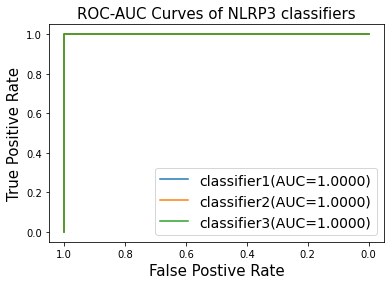

In [19]:
import matplotlib.pyplot as plt	
from sklearn.metrics import roc_auc_score, roc_curve

gbm_auc1 = roc_auc_score(y_test1, val_pred_pro1[:,1])  # 计算auc
gbm_fpr1, gbm_tpr1, gbm_threasholds1 = roc_curve(y_test1, val_pred_pro1[:,1])  # 计算ROC的值

gbm_auc2 = roc_auc_score(y_test2, val_pred_pro2[:,1])  # 计算auc
gbm_fpr2, gbm_tpr2, gbm_threasholds2 = roc_curve(y_test2, val_pred_pro2[:,1])  # 计算ROC的值

gbm_auc3 = roc_auc_score(y_test, val_pred_pro[:,1])  # 计算auc
gbm_fpr3, gbm_tpr3, gbm_threasholds3 = roc_curve(y_test, val_pred_pro[:,1])  # 计算ROC的值

plt.title("ROC-AUC Curves of NLRP3 classifiers",fontsize=15)
plt.xlabel('False Postive Rate',fontsize=15)  # specificity = 1 - np.array(gbm_fpr))
plt.ylabel('True Positive Rate',fontsize=15)  # sensitivity = gbm_tpr
plt.rcParams.update({'font.size': 14})
line1, = plt.plot(list(1 - np.array(gbm_fpr1)), gbm_tpr1, label = 'classifier1')
line2, = plt.plot(list(1 - np.array(gbm_fpr2)), gbm_tpr2, label = 'classifier2')
line3, = plt.plot(list(1 - np.array(gbm_fpr3)), gbm_tpr3, label = 'classifier3')
plt.legend(handles=[line1, line2, line3], labels=['classifier1(AUC=%.4f)' %(gbm_auc1),'classifier2(AUC=%.4f)' %(gbm_auc2),'classifier3(AUC=%.4f)' %(gbm_auc3)], loc='best')
plt.gca().invert_xaxis()  # 将X轴反转
plt.show()

Screening from FDA-approved drugs:

In [12]:
data = 'data/ZINC_VEC_forsale_fda/for-sale+fda.csv'
# SMILES = SmileToCanon(data,smiles=None)
SMILES = pd.read_csv(data,sep=',')['smiles']
X = get_vec6(SMILES,'ZINC_VEC_forsale_fda',model_weight,hidden_size=256,n_head=4,n_layer=2)
res = list(filter(None, SMILES)) 
print(len(res))
feature_path = 'data/ZINC_VEC_forsale_fda/vec_2_translate.csv' 
ZINC = pd.read_csv(feature_path)
col = [i for i in ZINC.columns if i not in ['smiles'] ]
ZINC_AVE = ZINC[col]
ZINC_AVE = ZINC_AVE.dropna(axis=0,how='all') 

100%|██████████| 1576/1576 [00:00<00:00, 12460.18it/s]


Built smi corpus file!


  0%|          | 0/197 [00:00<?, ?it/s]/home/guoyunxiang/smi2pharm/DTI/get_vec_function_translate.py:520: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vec_encode = vec_encode.append(vec,ignore_index=True)
100%|██████████| 197/197 [00:01<00:00, 155.23it/s]


1576


In [30]:
rs = 50
X_train, X_val, X_test, y_train, y_val, y_test= train_val_test_split(X_ave, y)
clf_multiclass = LGBMClassifier(num_leaves=77, min_data_in_leaf=100, max_depth=3,
                           learning_rate=0.0234, max_bin=478)
clf_multiclass.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
# clf_multiclass.fit(X_train,y_train)
val_pred = clf_multiclass.predict(ZINC_AVE)
val_pred_pro = clf_multiclass.predict_proba(ZINC_AVE)
ZINC_result = pd.DataFrame()
ZINC_result['ids'] = res
ZINC_result['pro'] = val_pred_pro[:,1]
ZINC_result['active'] = val_pred
result =ZINC_result.sort_values(by='pro' , ascending=False) 
result = result.drop_duplicates()
p= result[result['active'].isin([1])]
ZINC_info = pd.read_csv('data/ZINC_VEC_forsale_fda/for-sale+in-man.csv',sep=',')
ZINC_info.columns=['smiles','ids']
zinc_id_50 = pd.merge(ZINC_info,p,on='ids',how='right')
zinc_id_50
# zinc_id.to_csv('NLRP3/diff_epoch/4decoder/new_trfm_24_15_translate/1000nm_6_221results_trainval.csv',index=False)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


,smiles,ids,pro,active
0,ZINC000064033452,Cc1ccc(NC(=O)C2(c3ccc4c(c3)OC(F)(F)O4)CC2)nc1-...,0.729101,1
1,ZINC000008101127,CC1(C)C(C=C/C=C\C=C/C=C2/N(CCCCS(=O)(=O)O)c3cc...,0.711311,1
2,ZINC000003830264,C[C@H]1[C@H](NC(=O)/C(=N\OC(C)(C)C(=O)O)c2csc(...,0.658499,1
3,ZINC000003861599,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,0.643773,1
4,ZINC000003938652,CCOC(=O)O[C@]1(C(=O)COC(=O)CC)CC[C@H]2[C@@H]3C...,0.620135,1
5,ZINC000000601301,NS(=O)(=O)c1cc2c(cc1C(F)(F)F)N[C@@H](Cc1ccccc1...,0.596700,1
6,ZINC000084758235,Cc1ccn(-c2cc(Cl)ccc2[C@@H](Oc2cc(-c3ccc(C[C@H]...,0.594601,1
7,ZINC000094566092,COc1cc2nc(N3CCN(C(=O)[C@@H]4COc5ccccc5O4)CC3)n...,0.585277,1
8,ZINC000000897222,NS(=O)(=O)c1cc2c(cc1C(F)(F)F)N[C@H](Cc1ccccc1)...,0.575638,1
9,ZINC000004212945,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,0.565574,1


In [31]:
rs = 72
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_ave, y)
clf_multiclass = LGBMClassifier(num_leaves=63, min_data_in_leaf=66, max_depth=10,
                           learning_rate=0.0442, max_bin=447)
clf_multiclass.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
# clf_multiclass.fit(X_train,y_train)
val_pred = clf_multiclass.predict(ZINC_AVE)
val_pred_pro = clf_multiclass.predict_proba(ZINC_AVE)
ZINC_result = pd.DataFrame()
ZINC_result['ids'] = res
ZINC_result['pro'] = val_pred_pro[:,1]
ZINC_result['active'] = val_pred
result =ZINC_result.sort_values(by='pro' , ascending=False) 
result = result.drop_duplicates()
p= result[result['active'].isin([1])]
ZINC_info = pd.read_csv('data/ZINC_VEC_forsale_fda/for-sale+in-man.csv',sep=',')
ZINC_info.columns=['smiles','ids']
zinc_id_72 = pd.merge(ZINC_info,p,on='ids',how='right')
zinc_id_72

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


,smiles,ids,pro,active
0,ZINC000100055899,CC(C)OC(=O)[C@H](C)N[P@](=O)(CO[C@H](C)Cn1cnc2...,0.689747,1
1,ZINC000064033452,Cc1ccc(NC(=O)C2(c3ccc4c(c3)OC(F)(F)O4)CC2)nc1-...,0.686008,1
2,ZINC000003830264,C[C@H]1[C@H](NC(=O)/C(=N\OC(C)(C)C(=O)O)c2csc(...,0.681720,1
3,ZINC000003920027,CCC(=O)O[C@]1(C(=O)SCF)[C@H](C)C[C@H]2[C@@H]3C...,0.663592,1
4,ZINC000118912517,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=...,0.639665,1
5,ZINC000003861599,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,0.635176,1
6,ZINC000004212851,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,0.614392,1
7,ZINC000096272772,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,0.599995,1
8,ZINC000043100709,CC(=O)Nc1cccc(-n2c(=O)n(C3CC3)c(=O)c3c(Nc4ccc(...,0.596492,1
9,ZINC000003920028,CCC(=O)O[C@]1(C(=O)CCl)[C@@H](C)C[C@H]2[C@@H]3...,0.593311,1


In [32]:
rs = 77
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_ave, y)
clf_multiclass = LGBMClassifier(num_leaves=51, min_data_in_leaf=79, max_depth=7,
                           learning_rate=0.0246, max_bin=319)
clf_multiclass.fit(np.concatenate([X_train,X_val]),np.concatenate([y_train,y_val]))
# clf_multiclass.fit(X_train,y_train)
val_pred = clf_multiclass.predict(ZINC_AVE)
val_pred_pro = clf_multiclass.predict_proba(ZINC_AVE)
ZINC_result = pd.DataFrame()
ZINC_result['ids'] = res
ZINC_result['pro'] = val_pred_pro[:,1]
ZINC_result['active'] = val_pred
result =ZINC_result.sort_values(by='pro' , ascending=False) 
result = result.drop_duplicates()
p= result[result['active'].isin([1])]
ZINC_info = pd.read_csv('data/ZINC_VEC_forsale_fda/for-sale+in-man.csv',sep=',')
ZINC_info.columns=['smiles','ids']
zinc_id_77 = pd.merge(ZINC_info,p,on='ids',how='right')
zinc_id_77

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


,smiles,ids,pro,active
0,ZINC000003861599,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,0.620461,1
1,ZINC000003830264,C[C@H]1[C@H](NC(=O)/C(=N\OC(C)(C)C(=O)O)c2csc(...,0.611041,1
2,ZINC000064033452,Cc1ccc(NC(=O)C2(c3ccc4c(c3)OC(F)(F)O4)CC2)nc1-...,0.607414,1
3,ZINC000026011099,COC(=O)C[C@](O)(CCCC(C)(C)O)C(=O)O[C@@H]1C(OC)...,0.604524,1
4,ZINC000043450324,COC(=O)C[C@](O)(CCCC(C)(C)O)C(=O)O[C@@H]1C(OC)...,0.589423,1
5,ZINC000098023177,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,0.582049,1
6,ZINC000043450326,COC(=O)C[C@@](O)(CCCC(C)(C)O)C(=O)O[C@@H]1C(OC...,0.575972,1
7,ZINC000008101127,CC1(C)C(C=C/C=C\C=C/C=C2/N(CCCCS(=O)(=O)O)c3cc...,0.571465,1
8,ZINC000004214700,Cc1nc2n(c(=O)c1CCN1CCC(c3noc4cc(F)ccc34)CC1)CC...,0.570229,1
9,ZINC000001481956,Cc1nc2n(c(=O)c1CCN1CCC(c3noc4cc(F)ccc34)CC1)CC...,0.570229,1


In [33]:
def merge_df(df1,df2,df3,col_on):
    cols_to_use_12 = df1.columns.difference(df2.columns.drop(col_on))
    common1 = pd.merge(df2,df1[cols_to_use_12],on=col_on,how='inner')
    cols_to_use_13 = df1.columns.difference(df3.columns.drop(col_on))
    common2 = pd.merge(df3,df1[cols_to_use_13],on=col_on,how='inner')
    cols_to_use_23 = df2.columns.difference(df3.columns.drop(col_on))
    common3 = pd.merge(df3,df2[cols_to_use_23],on=col_on,how='inner')
    cols_to_use = df3.columns.difference(common1.columns.drop(col_on))
    common_3 = pd.merge(common1,df3[cols_to_use],on=col_on,how='inner')

    cols_to_use_common_12 = common1.columns.difference(common2.columns.drop(col_on))
    final_12 = pd.merge(common2,common1[cols_to_use_common_12],on=col_on,how='outer')
    cols_to_use_common_13 = final_12.columns.difference(common3.columns.drop(col_on))
    final = pd.merge(common3,final_12[cols_to_use_common_13],on=col_on,how='outer')

    # cols_to_use = final.columns.difference(DHR_DATA.columns.drop(col_on))
    # final = pd.merge(DHR_DATA,final[cols_to_use],on=col_on,how='inner')

    return common1,common2,common3,common_3,final

In [38]:
common1,common2,common3,common_3,final = merge_df(zinc_id_50,zinc_id_72,zinc_id_77,col_on='smiles')

In [39]:
final

,smiles,ids,pro,active
0,ZINC000003861599,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,0.620461,1.0
1,ZINC000003830264,C[C@H]1[C@H](NC(=O)/C(=N\OC(C)(C)C(=O)O)c2csc(...,0.611041,1.0
2,ZINC000064033452,Cc1ccc(NC(=O)C2(c3ccc4c(c3)OC(F)(F)O4)CC2)nc1-...,0.607414,1.0
3,ZINC000026011099,NaN,NaN,NaN
4,ZINC000098023177,NaN,NaN,NaN
5,ZINC000008101127,NaN,NaN,NaN
6,ZINC000094566092,NaN,NaN,NaN
7,ZINC000094566093,NaN,NaN,NaN
8,ZINC000004212945,NaN,NaN,NaN
9,ZINC000003938652,NaN,NaN,NaN
